# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [ ]:
import numpy as np
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go t")
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input, MaxPooling2D,ZeroPadding2D,Conv2DTranspose, concatenate

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone git://github.com/chaeb/Reconstruct-Masked-Face.git

import sys
sys.path.append('/content/drive/MyDrive/DL')
print(sys.path)

import load_data

PATH = '/content/Reconstruct-Masked-Face'
train_mask_image, train_image, val_mask_image, val_image, test_mask_image, test_image = load_data.get(PATH)

Cloning into 'Reconstruct-Masked-Face'...
remote: Enumerating objects: 9008, done.
remote: Total 9008 (delta 0), reused 0 (delta 0), pack-reused 9008
Receiving objects: 100% (9008/9008), 144.84 MiB | 17.82 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Checking out files: 100% (9000/9000), done.
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/DL']
Train no mask image shape: (3500, 128, 128, 3)
Validation no mask image shape: (500, 128, 128, 3)
Test no mask image shape (500, 128, 128, 3)


In [ ]:
latent_dim = 256
SIZE=128

## Create a sampling layer

In [ ]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        return z_mean + tf.exp(0.5 * z_log_var)


## Build the encoder

In [ ]:
encoder_inputs = Input((SIZE, SIZE, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
z_mean = layers.Dense(latent_dim, name="z_mean")(conv5)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(conv5)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Build the decoder

In [ ]:
latent_inputs = keras.Input(shape=[8,8,latent_dim])
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(latent_inputs)
up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
decoder_outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 256)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 512)         1180160   
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       524544    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       131200    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       1475

## Define the VAE as a `Model` with a custom `train_step`

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[1], reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train the VAE

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(train_mask_image, train_image, epochs=200,  batch_size=32)

Epoch 1/200
110/110 [==============================] - 51s 142ms/step - loss: 11196.9002 - reconstruction_loss: 11150.0859 - kl_loss: 1.2148
Epoch 2/200
110/110 [==============================] - 15s 133ms/step - loss: 11154.8667 - reconstruction_loss: 10865.7070 - kl_loss: 26.1290
Epoch 3/200
110/110 [==============================] - 15s 134ms/step - loss: 10056.0285 - reconstruction_loss: 9958.1094 - kl_loss: 3.3120
Epoch 4/200
110/110 [==============================] - 14s 132ms/step - loss: 9767.6789 - reconstruction_loss: 9736.7617 - kl_loss: 2.6282
Epoch 5/200
110/110 [==============================] - 14s 131ms/step - loss: 9688.4008 - reconstruction_loss: 9667.1260 - kl_loss: 2.3773
Epoch 6/200
110/110 [==============================] - 14s 131ms/step - loss: 9616.7623 - reconstruction_loss: 9627.9570 - kl_loss: 2.1451
Epoch 7/200
110/110 [==============================] - 14s 131ms/step - loss: 9617.6840 - reconstruction_loss: 9597.5596 - kl_loss: 1.9754
Epoch 8/200
110/110 [

In [ ]:
import matplotlib.pyplot as plt

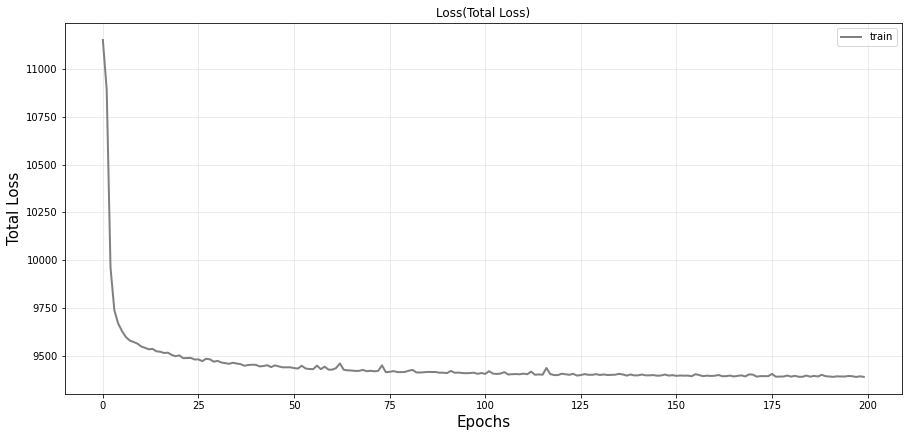

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(history.epoch, history.history['loss'], label = 'train', color = 'gray', linewidth=2)
plt.title('Loss(Total Loss)')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Total Loss', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


In [ ]:
divided = [i/(128*128*3) for i in history.history['loss']]

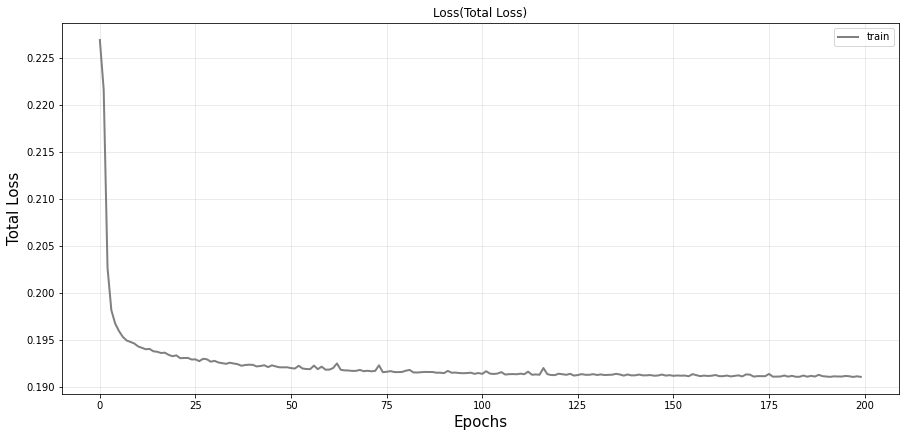

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(history.epoch, divided, label = 'train', color = 'gray', linewidth=2)
plt.title('Loss(Total Loss)')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Total Loss', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


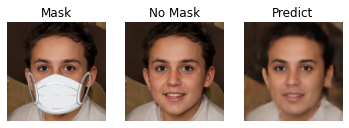

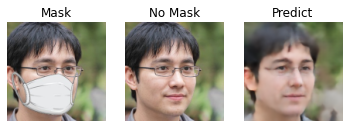

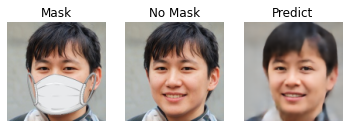

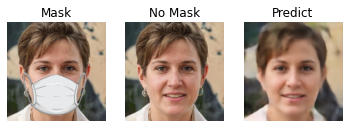

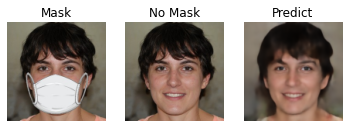

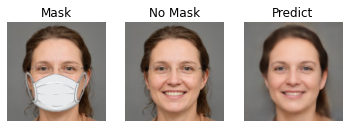

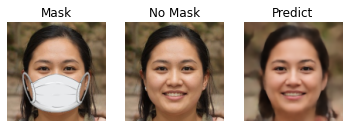

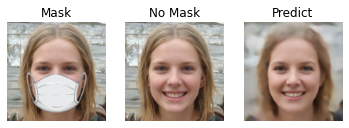

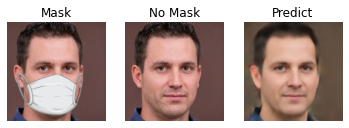

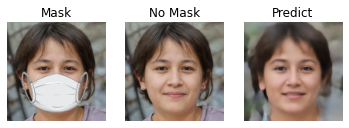

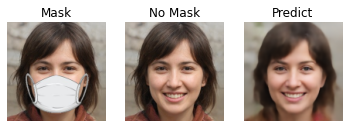

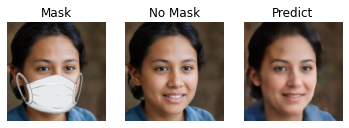

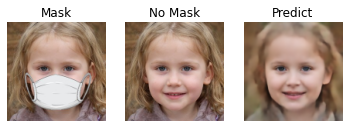

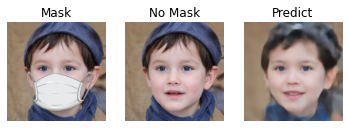

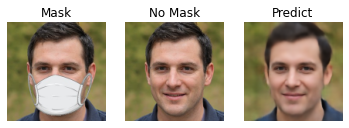

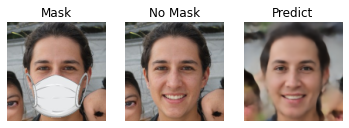

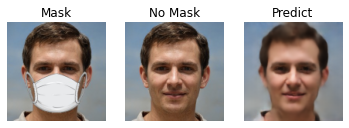

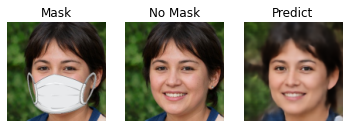

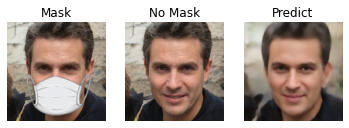

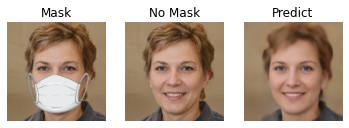

In [ ]:
_,_,z = encoder(test_mask_image)
predict = decoder(z)
for i in range(0,20) :
  plt.subplot(1,3,1)
  plt.title('Mask')
  plt.axis('off')
  plt.imshow(test_mask_image[i])
  plt.subplot(1,3,2)
  plt.title('No Mask')
  plt.axis('off')
  plt.imshow(test_image[i])
  plt.subplot(1,3,3)
  plt.title('Predict')
  plt.imshow(predict[i])
  plt.axis('off')
  plt.show()

In [ ]:
def SSIM(reconstructed, truth):
    return tf.image.ssim(reconstructed, truth, 1.0)

In [ ]:
tf.reduce_mean(SSIM(predict, test_image))

<tf.Tensor: shape=(), dtype=float32, numpy=0.75894946>

In [ ]:

import cv2
from PIL import Image

In [ ]:
name = 'YM_Final'
im = Image.open('/content/'+name+'.jpeg')

imResize = im.resize((256,256), Image.ANTIALIAS)
imResize.save('/content/'+name+'_resized.jpg','JPEG',quality=90)

In [ ]:
YM = cv2.imread('/content/YM_Final_resized.jpg',1)
SIZE=128
YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)

YM = cv2.resize(YM, (SIZE, SIZE))

# normalizing image 
YM = YM.astype('float32') / 255.0

YM = YM.reshape(1,128,128,3)

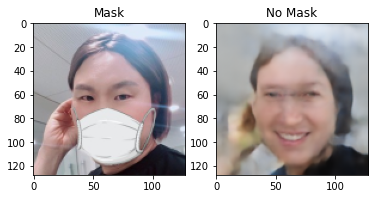

In [ ]:
_,_,z = encoder(YM)
predict_YM = decoder(z)
plt.subplot(1,2,1)
plt.title('Mask')
plt.imshow(YM[0])
plt.subplot(1,2,2)
plt.title('No Mask')
plt.imshow(predict_YM[0])

In [ ]:
SSIM(YM, predict_YM)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.57938737], dtype=float32)>

In [ ]:
def plot_test_img(path) : 
  img = cv2.imread(path,1)
  SIZE=128
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = cv2.resize(img, (SIZE, SIZE))

  # normalizing image 
  img = img.astype('float32') / 255.0

  img = img.reshape(1,128,128,3)

  _,_,z = encoder(img)
  predict_img = decoder(z)
  plt.subplot(1,2,1)
  plt.title('Mask')
  plt.imshow(img[0])
  plt.subplot(1,2,2)
  plt.title('No Mask')
  plt.imshow(predict_img[0])

  print('SSIM : ', SSIM(img, predict_img))

SSIM :  tf.Tensor([0.7001532], shape=(1,), dtype=float32)


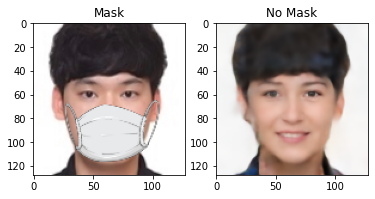

In [ ]:
plot_test_img('/content/JS.JPEG')

SSIM :  tf.Tensor([0.71217036], shape=(1,), dtype=float32)


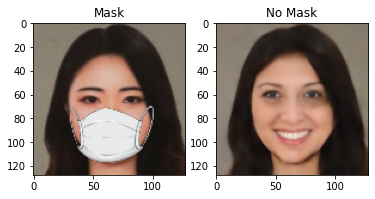

In [ ]:
plot_test_img('/content/gyul3.JPEG')

SSIM :  tf.Tensor([0.66147286], shape=(1,), dtype=float32)


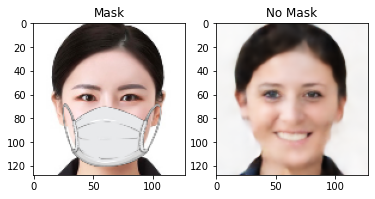

In [ ]:
plot_test_img('/content/CB_test2.JPEG')

SSIM :  tf.Tensor([0.46316257], shape=(1,), dtype=float32)


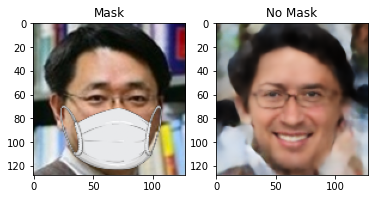

In [ ]:
plot_test_img('/content/JW3.JPEG')

SSIM :  tf.Tensor([0.54524755], shape=(1,), dtype=float32)


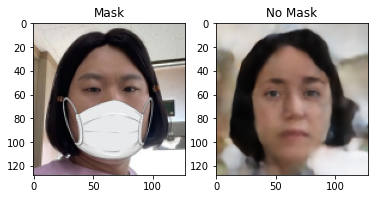

In [ ]:
plot_test_img('/content/YM_pink_resized.jpg')

SSIM :  tf.Tensor([0.5580986], shape=(1,), dtype=float32)


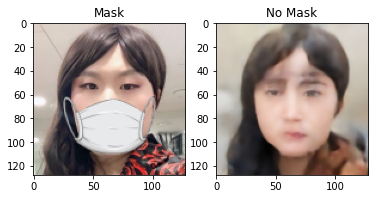

In [ ]:
plot_test_img('/content/YM_red_resized.jpg')

SSIM :  tf.Tensor([0.4633722], shape=(1,), dtype=float32)


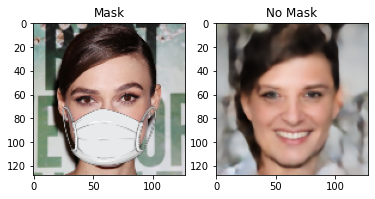

In [ ]:
plot_test_img('/content/E4BF9B47-D4DB-4F73-99E1-06FE2DEE3A06.JPEG')